In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow.keras import layers
from glob import glob
import gc


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 34.9 MB/s 


In [3]:
VERSION = "20200220"
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6034  100  6034    0     0  18340      0 --:--:-- --:--:-- --:--:-- 18340
Traceback (most recent call last):
  File "pytorch-xla-env-setup.py", line 182, in <module>
    run_setup(args)
  File "pytorch-xla-env-setup.py", line 144, in run_setup
    version = get_version(args.version)
  File "pytorch-xla-env-setup.py", line 75, in get_version
    f'Oldest nightly version build with CUDA available is {OLDEST_GPU_VERSION}')
ValueError: Oldest nightly version build with CUDA available is 2020-07-07 00:00:00


In [4]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import os
import timm
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time
from PIL import Image 


## Scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
def to_be_balanced(df) :

  '''
  아이디어는 일단 RAM이 터지면 안 되니까 기존 이미지 수를 class 별로 최대한 유지하면서 이상치"들"과 정상데이터의 비율을 1:1로 최대한 맞추려고 했음
  그 비율이 되게 하는 수를 n이라고 하면.. 정상데이터 중에서 random으로 n개를 고르고
  이상치는 그 n에 맞게 복사시켜서 추가시키는 걸로!

  '''
  ## 새로 쓸 y_train 생성
  balanced_train_y = pd.DataFrame(columns = df.columns)
  class_lst = df['class'].unique()
  ## class 별로 이상치 조정 시작
  for cls in class_lst :
    cls_df = df[df['class']==cls]
    print(f'{cls} class 의 이상치 조정을 시작합니다.')

    ## 적절한 수 유지 계산
    total_ = cls_df.shape[0] 
    num_inner_class = len(cls_df['label'].unique()) 
    good_num =  total_ // num_inner_class

    ## good_num과 이상치들의 평균 수의 차이 계산
    avg_lier = np.mean(cls_df['label'].value_counts()[1:].values)  ## 보통 정상치가 제일 많으니까.. [1:]하면 이상치 나오더라구용
    multi_ply = (good_num//avg_lier).astype('int32') 

    g_idx = []
    b_idx = []
    for idx, i  in enumerate(cls_df['label']) :
      
      ## 정상 데이터 추려내기
      if i.endswith('-good') :   ## 정상 데이터라면 
        g_idx.append(idx)        ## 그 인덱스 list에 추가하고  
      
      ## 이상치 추려내기
      if not i.endswith('-good') : 
          b_idx.append(idx)


    ## g_idx 중, 랜덤으로 good_num만큼 선택, 선택받은 아이들이 됨
    sel = np.random.choice(g_idx,good_num)

    ## trian_y에서의 index가 뭔지 알아내기
    real_idx = cls_df.iloc[sel,:].index

    lier_real = cls_df.iloc[b_idx,:].index ##Multi_ply 만큼 concat반복해줄 예정
    bad_ = df.iloc[lier_real]

    balanced_train_y = pd.concat([balanced_train_y ,df.iloc[real_idx,:]])
    for i in range(multi_ply) :
      balanced_train_y = pd.concat([balanced_train_y, bad_])

    ## 다 끝나면 메모리 비우기~
    gc.collect()

  print('이상치 조정 끝')

  return balanced_train_y

In [7]:
# ## 여기부터 ZIP FILE 압축 풀기 ##
# %cd /content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re
# !unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/open.zip"

## This code was used for download original zip file

In [8]:
## 파일 불러오기
# Trian Data unzip 
%cd /content
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/train.zip"
print("train file Unzip is Completed!!")

# Define Train Set
train = sorted(glob('/content/train/*.png'))

# Test Data unzip 
%cd /content
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/test.zip"
print("test file Unzip is Completed!!")

# Define Test Set
test = sorted(glob('/content/test/*.png'))

/content
train file Unzip is Completed!!
/content
test file Unzip is Completed!!


In [9]:
train_y = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/train_df.csv")
train_y = train_y.iloc[:,1:]

In [10]:
balanced_train_y = to_be_balanced(train_y)
balanced_train_y =  balanced_train_y.reset_index(drop=True)

transistor class 의 이상치 조정을 시작합니다.
capsule class 의 이상치 조정을 시작합니다.
wood class 의 이상치 조정을 시작합니다.
bottle class 의 이상치 조정을 시작합니다.
screw class 의 이상치 조정을 시작합니다.
cable class 의 이상치 조정을 시작합니다.
carpet class 의 이상치 조정을 시작합니다.
hazelnut class 의 이상치 조정을 시작합니다.
pill class 의 이상치 조정을 시작합니다.
metal_nut class 의 이상치 조정을 시작합니다.
zipper class 의 이상치 조정을 시작합니다.
leather class 의 이상치 조정을 시작합니다.
toothbrush class 의 이상치 조정을 시작합니다.
tile class 의 이상치 조정을 시작합니다.
grid class 의 이상치 조정을 시작합니다.
이상치 조정 끝


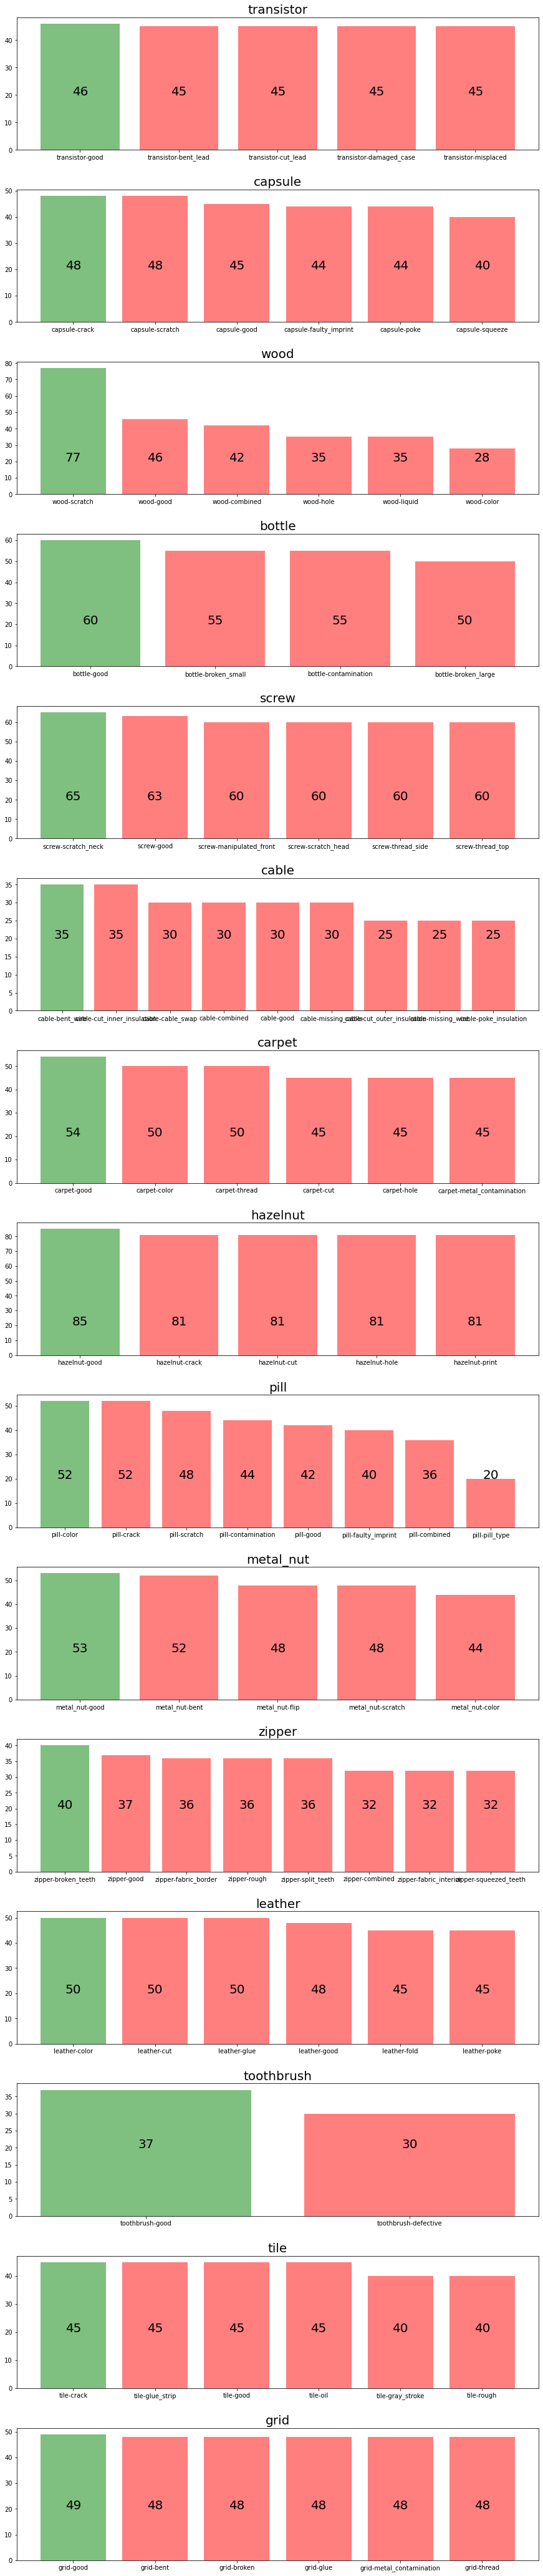

In [11]:
## 시각화

classList = balanced_train_y['class'].unique()
labelList = balanced_train_y['label'].unique()
labelCount = balanced_train_y[['class', 'label']].groupby('label').count().rename(columns={'class': 'count'})
anomaly_dict = {}
for className in classList:
    df = pd.DataFrame(labelCount[labelCount.index.str.contains(className)]).sort_values(by='count', ascending=False)
    anomaly_dict[className] = df
fig, axs = plt.subplots(15, 1, figsize=(15, 15*5))
fig.subplots_adjust(hspace = .3)
axs = axs.ravel()

for i, (className, df) in enumerate(anomaly_dict.items()):
    colors = ['red' for i in range(len(df.index))]
    colors[0] = 'green'
    axs[i].bar(df.index, df.iloc[:, 0], color=colors, alpha=0.5)
    axs[i].set_title(className, fontsize=20)
    for j, value in enumerate(df.iloc[:, 0]):
        axs[i].text(j, 20, df.iloc[:, 0][j], ha='center', fontsize=20)

# CONFIG

In [12]:
img_size = 300 ## Recommended Resolution for EFN V2 B3

model_name = 'V2B3_lr_test_content_test_30epo.pt'
sub_name = 'V2B3_lr_test_content_test_30epo.csv'


seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


batch = 32
epochs = 30


# AUGMENTATION

In [13]:
import torchvision
import torchvision.transforms as transforms

base_transform = transforms.Compose([
          transforms.Resize((img_size)),
          transforms.ToTensor(),
])

aug_transform = transforms.Compose([
    transforms.Normalize(mean = [0.433038, 0.403458, 0.394151],
    std = [0.181572, 0.174035, 0.163234]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90, expand=False),
    transforms.RandomResizedCrop(size = (300,300), scale = (0.7, 1))
])

test_transform = transforms.Compose([
transforms.Normalize(mean = [0.418256, 0.393101, 0.386632],
      std = [0.195055, 0.190053, 0.185323])
])

In [14]:
train_list = []
for i in balanced_train_y['file_name']:
  train_list.append("/content/train/{}".format(i))

In [15]:
train_labels = balanced_train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

# DATASET CLASS

In [16]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx] ## Allocating Path 
        img = Image.open(img_path) 
        img = base_transform(img) ## Resize To (img_size) + ToTensor
        if img.size()[0] ==1 :
          img = torch.stack((img,img,img)).squeeze()
        if self.mode=='train':               
            img = aug_transform(img)  ## RandomCrop

               
        if self.mode=='test':
          img = test_transform(img)


        label = self.labels[idx]
        return img, label

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

# DATA LOADER

In [17]:
batch_size = 32

# Train
train_dataset = Custom_dataset(np.array(train_list), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch)
del train_list

In [18]:
# Test
test_dataset = Custom_dataset(np.array(test), np.array(["tmp"]*len(test)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch)
del test

# SCORE FUNCTION

In [19]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

In [20]:
torch.cuda.empty_cache()

In [21]:
device = torch.device('cuda') ## 실제로 모델 돌릴 때는 cuda로 바꿀 것 지금은 imbal로 돌아가냐 안 돌아가냐만 test

In [22]:
net = Network().to("cuda:0") ## 나중에 주석 푸셈

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_b3-57773f13.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_b3-57773f13.pth


# Train

In [23]:

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 
scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0 = 5, T_mult = 1, eta_min = 1e-5)

## For Saving Best MODEL
highest_f1 = 0

best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        gc.collect()
        torch.cuda.empty_cache()
        
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
    
    scheduler.step()    ## lr_scheduler step
    print('!! LR_SCHEDULER is Worked !!')
    
    train_f1 = score_function(train_y, train_pred)


    if train_f1 > highest_f1:
      highest_f1 = train_f1
      

      torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/SAVING MODEL/{model_name}")
      print('!! Best Trained Model is Saved !!')



    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

!! LR_SCHEDULER is Worked !!
!! Best Trained Model is Saved !!
epoch : 1/30    time : 258s/7470s
TRAIN    loss : 4.15065    f1 : 0.06515
!! LR_SCHEDULER is Worked !!
!! Best Trained Model is Saved !!
epoch : 2/30    time : 249s/6968s
TRAIN    loss : 3.27660    f1 : 0.20024
!! LR_SCHEDULER is Worked !!
!! Best Trained Model is Saved !!
epoch : 3/30    time : 249s/6726s
TRAIN    loss : 2.60141    f1 : 0.28222
!! LR_SCHEDULER is Worked !!
!! Best Trained Model is Saved !!
epoch : 4/30    time : 249s/6482s
TRAIN    loss : 2.12745    f1 : 0.35930
!! LR_SCHEDULER is Worked !!
!! Best Trained Model is Saved !!
epoch : 5/30    time : 248s/6192s
TRAIN    loss : 1.80042    f1 : 0.44220
!! LR_SCHEDULER is Worked !!
!! Best Trained Model is Saved !!
epoch : 6/30    time : 249s/5967s
TRAIN    loss : 1.56445    f1 : 0.48699
!! LR_SCHEDULER is Worked !!
!! Best Trained Model is Saved !!
epoch : 7/30    time : 248s/5711s
TRAIN    loss : 1.40993    f1 : 0.55006
!! LR_SCHEDULER is Worked !!
!! Best Trai

In [24]:
model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/SAVING MODEL/{model_name}'))

model.eval()
f_pred = []

print("Start the Inference")
with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

print("Finish the Inference")

Start the Inference
Finish the Inference


In [25]:
submission = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [26]:
submission.to_csv(f"/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/SAVING SUBMISSION/{sub_name}", index = False)